```{contents}
```
## State Diff

**State Diff** in LangGraph refers to the **incremental change** that a node produces to the shared workflow state, rather than returning the entire state object.
This mechanism is fundamental for **efficiency, correctness, traceability, and persistence** in large-scale LLM systems.

---

### **1. Motivation**

LangGraph workflows operate on a **global shared state** that evolves as the graph executes.
Updating the entire state at each node would be:

* computationally expensive
* error-prone
* difficult to audit
* inefficient to persist and replay

Therefore, LangGraph adopts a **diff-based update model**.

> **Nodes return only what they change.**

---

### **2. Conceptual Model**

Let the current state be:

```python
Sₜ = { a: 3, b: 10, c: "hello" }
```

A node returns:

```python
Δ = { b: 11 }
```

LangGraph computes:

```python
Sₜ₊₁ = merge(Sₜ, Δ)
     = { a: 3, b: 11, c: "hello" }
```

This `Δ` is the **state diff**.

---

### **3. Formal Definition**

Let:

* `Sₜ` = state before node execution
* `Δₙ` = state diff produced by node *n*
* `R` = reducer (merge function)

Then:

```
Sₜ₊₁ = R(Sₜ, Δₙ)
```

Reducers are deterministic functions that combine the old state with the diff.

---

### **4. State Diff in Practice**

### **State Schema**

```python
class State(TypedDict):
    messages: list
    step: int
    done: bool
```

### **Node returns only a diff**

```python
def reasoning_node(state):
    new_message = "Thinking..."
    return {"messages": state["messages"] + [new_message]}
```

The node does **not** return `step` or `done`.
LangGraph preserves them automatically.

---

### **5. Reducers**

Reducers define **how diffs are merged**.

```python
from langgraph.graph import StateGraph

def add_messages(old, new):
    return old + new

class State(TypedDict):
    messages: Annotated[list, add_messages]
    step: int
    done: bool
```

Now when a node returns:

```python
{"messages": ["Hello"]}
```

LangGraph performs:

```python
state["messages"] = add_messages(state["messages"], ["Hello"])
```

---

### **6. Why State Diff Matters**

| Problem     | Without Diff         | With Diff             |
| ----------- | -------------------- | --------------------- |
| Performance | Full copy each step  | Minimal update        |
| Correctness | Risk of overwriting  | Safe merges           |
| Persistence | Large snapshots      | Compact deltas        |
| Debugging   | Hard to inspect      | Exact changes visible |
| Replay      | Recompute everything | Apply diffs           |

---

### **7. State Diff & Checkpointing**

Each checkpoint stores:

* previous state `Sₜ`
* applied diff `Δₙ`
* node metadata

Replaying becomes:

```
S₀ + Δ₁ + Δ₂ + Δ₃ + ... + Δₙ
```

This enables **deterministic recovery** and **time-travel debugging**.

---

### **8. Example: Full Workflow**

```python
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END

def add_msgs(a, b): return a + b

class State(TypedDict):
    messages: Annotated[list, add_msgs]
    count: int

def node1(state):
    return {"messages": ["Hi"], "count": state["count"] + 1}

def node2(state):
    return {"messages": ["Bye"]}

builder = StateGraph(State)
builder.add_node("n1", node1)
builder.add_node("n2", node2)

builder.set_entry_point("n1")
builder.add_edge("n1", "n2")
builder.add_edge("n2", END)

graph = builder.compile()

result = graph.invoke({"messages": [], "count": 0})
print(result)
```

**Execution evolution**

| Step  | Diff                           | State                      |
| ----- | ------------------------------ | -------------------------- |
| Start | —                              | `{messages: [], count: 0}` |
| n1    | `{messages: ["Hi"], count: 1}` | `{["Hi"], 1}`              |
| n2    | `{messages: ["Bye"]}`          | `{["Hi","Bye"], 1}`        |

---

### **9. Relationship to Production Systems**

State diff is identical in spirit to:

* database **write-ahead logs**
* distributed system **event sourcing**
* blockchain **transaction deltas**

This is why LangGraph scales cleanly to **long-running autonomous systems**.

---

### **10. Mental Model**

> **LangGraph does not move state.
> It moves change.**

That design choice enables reliability, scalability, and observability.

### Demonstration

In [1]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END

def append_messages(old, new):
    return old + new

class State(TypedDict):
    messages: Annotated[list, append_messages]
    step: int
    done: bool

def reason(state):
    return {
        "messages": [f"Thinking at step {state['step']}"],
        "step": state["step"] + 1
    }

def check(state):
    return {"done": state["step"] >= 3}

builder = StateGraph(State)

builder.add_node("reason", reason)
builder.add_node("check", check)

builder.set_entry_point("reason")
builder.add_edge("reason", "check")

builder.add_conditional_edges(
    "check",
    lambda s: END if s["done"] else "reason",
    {"reason": "reason", END: END}
)

graph = builder.compile()


In [2]:
initial_state = {"messages": [], "step": 0, "done": False}
final_state = graph.invoke(initial_state)
print(final_state)


{'messages': ['Thinking at step 0', 'Thinking at step 1', 'Thinking at step 2'], 'step': 3, 'done': True}


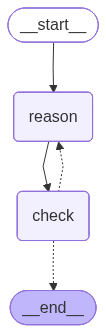

In [4]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())